In [1]:
import xml.etree.ElementTree as ET
import os
from tqdm import tqdm
import json
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
class Intension:
    def __init__(self, root, first=None, second=None, third=None, index=None) -> None:
        paths = self.find_xml_files(root)
        if not first:
            first = self.first_pass(paths)
            with open("first_pass.json", "w") as outj:
                json.dump(first, outj, indent=4, ensure_ascii=False)
        else:
            with open(first, 'r') as inj:
                self.first = json.load(inj)
        if not second:
            second = self.second_pass(first, paths)
            with open("second_pass.json", "w") as outj:
                json.dump(second, outj, indent=4, ensure_ascii=False)
        else:
            with open(second, 'r') as inj:
                self.second = json.load(inj)
        if not third:
            third = self.third_pass(second, paths, index)
            with open("third_pass.json", "w") as outj:
                json.dump(third, outj, indent=4, ensure_ascii=False)
        else:
            with open(third, 'r') as inj:
                self.third = json.load(inj)
        
        print("and done!")

    def first_pass(self, paths):
        target_pos = ['SUBST', 'VERB', 'ADJ', 'ADV']
        fp = {pos:{} for pos in target_pos}
        for path in tqdm(paths, desc="Getting word counts"):
            sentences = self.read_sentences_from_bnc(path)
            for sentence in sentences:
                for word, pos in sentence:
                    if pos in target_pos:
                        if word not in fp[pos]:
                            fp[pos][word] = 1
                        else:
                            fp[pos][word] += 1
        return fp
    
    def second_pass(self, first_stem, paths):
        #First a little rearranging, we only want the top 10k across all categories.
        target_pos = ['SUBST', 'VERB', 'ADJ', 'ADV']
        first = {pos:{} for pos in target_pos}
        second = {pos:{} for pos in target_pos}
        word_counts = sorted([(word, k, count) for k,v in first_stem.items() for word, count in v.items()], key= lambda x:x[2], reverse = True)
        for word, pos, count in word_counts[1000:11000]:
            if word not in first[pos]:
                first[pos][word] = count
        #Curious about the balance there. 
        for k,v in first.items():
            print(f"The amount of words in {k} is {len(v)}")
        for path in tqdm(paths, desc="Getting collocations, i.e. second pass"):
            sentences = self.read_sentences_from_bnc(path)
            for sentence in sentences:
                for word, pos in sentence:
                    if pos in target_pos:
                        if word in first[pos]:
                            if word not in second[pos]:
                                second[pos][word] = {pos:{} for pos in target_pos}
                            for w2, p2 in sentence:
                                if p2 in target_pos:
                                    if (word, pos) == (w2,p2): continue
                                    if w2 in first[p2]:
                                        if w2 in second[pos][word][p2]:
                                            second[pos][word][p2][w2] += 1
                                        else:
                                            second[pos][word][p2][w2] = 1
        return second

    def third_pass(self, second, paths, idx):
        third = {}
        if not idx:
            idx = {}
            counter = 0
            for k,v in second.items():
                for k2, v2 in v.items():
                    for v3 in v2.values():
                        for vec in v3:
                            if vec not in idx:
                                idx[vec] = counter
                                counter +=1
            with open("index.json", "w") as outj:
                json.dump(idx, outj, indent=4, ensure_ascii=False)
        else:
            with open(idx, 'r') as inj:
                idx = json.load(inj)
        for k,v in second.items():
            for k2, v2 in tqdm(v.items(), desc = "building out a section"):
                third[k2] = [0] * len(idx)
                for v3 in v2.values():
                    for vec, count in v3.items():
                        third[k2][idx[vec]] = count

        print("and done!")

        return third

    def cosine_similarity(self, vec1, vec2):
        """Compute the cosine similarity between two vectors."""
        dot_product = np.dot(vec1, vec2)
        norm_a = np.linalg.norm(vec1)
        norm_b = np.linalg.norm(vec2)
        return dot_product / (norm_a * norm_b)

    def find_nearest_neighbors(self, word_vec_dict, target_vector, n):
        """Find the n nearest neighbors of target_vector in word_vec_dict based on cosine similarity."""
        target_vector = word_vec_dict[target_vector]
        similarities = {}
        # Calculate similarity between target vector and each vector in the dictionary
        for word, vector in word_vec_dict.items():
            similarity = self.cosine_similarity(target_vector, vector)
            similarities[word] = similarity
        
        # Sort by similarity descending
        sorted_similarities = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
        
        # Return the top n neighbors
        return sorted_similarities[:n]


    
    def read_sentences_from_bnc(self, file_path):
        # Load and parse the XML file
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Extract sentences enclosed in <s> tags
        sentences = []
        for sentence in root.findall('.//s'):  # Find all <s> tags, which denote sentences
            current_sentence = []
            for word in sentence.findall('.//w'):  # Find all <w> tags within the sentence
                text = word.text.strip() if word.text else ""
                pos = word.attrib.get('pos', 'N/A')  # Get the part of speech if available
                current_sentence.append((text, pos))
            sentences.append(current_sentence)

        return sentences
    
    def find_xml_files(self, root_folder):
        xml_files = []
        # Walk through each directory in the root folder
        for dirpath, dirnames, filenames in os.walk(root_folder):
            # Check each file to see if it ends with '.xml'
            for file in filenames:
                if file.endswith('.xml'):
                    # Construct full path relative to the root folder
                    full_path = os.path.relpath(os.path.join(root_folder, dirpath, file), start=root_folder)
                    xml_files.append(full_path)
        return xml_files



In [3]:
myintensionality = Intension('Texts', first = 'first_pass.json', second = 'second_pass.json', third='third_pass.json', index="index.json")

and done!


In [6]:
mytarget = random.choice(list(myintensionality.third.keys()))
print(f"My target is {mytarget}")
result = myintensionality.find_nearest_neighbors(myintensionality.third, mytarget, 20)
print(result)

My target is cottage
[('cottage', 0.9999999999999998), ('lived', 0.5269557813130528), ('cottages', 0.5238549589232591), ('stayed', 0.5041192159784692), ('street', 0.5036192645434734), ('kitchen', 0.5033953687850526), ('tiny', 0.5024748758915223), ('huge', 0.5018748111543766), ('beautiful', 0.5004934340140398), ('ran', 0.5003378196466247), ('gate', 0.49834132394820874), ('liked', 0.4975945710690204), ('while', 0.4963133070844926), ('walked', 0.4961929893817625), ('lady', 0.488731322031499), ('walk', 0.4881541328157067), ('somewhere', 0.4878517738608313), ('lovely', 0.4875351786640134), ('hill', 0.4872792492817115), ('standing', 0.4868625230057259)]


My target is Al


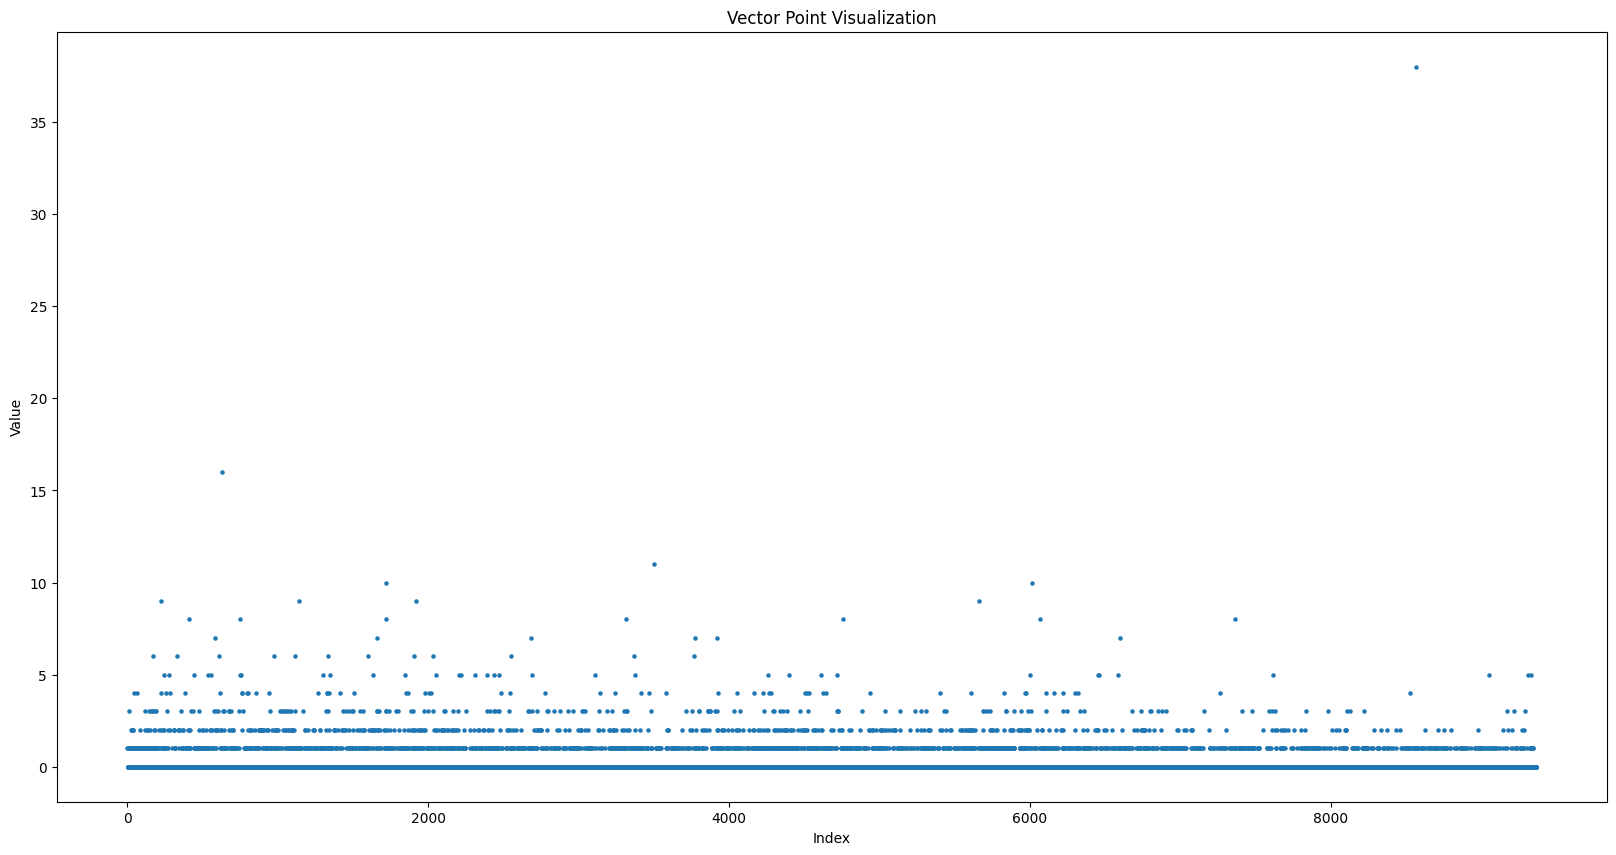

In [8]:
def plot_vector_points(vector, title="Vector Point Visualization", dot_size=1):
    plt.figure(figsize=(20, 10))  # Set the figure size
    plt.scatter(range(len(vector)), vector, s=dot_size)  # Plot the vector values as points, 's' controls the size of the points
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

# Example usage
mytarget = random.choice(list(myintensionality.third.keys()))
print(f"My target is {mytarget}")
vector = myintensionality.third[mytarget]  # Example vector, adjust to your actual vector
plot_vector_points(vector, dot_size=5)

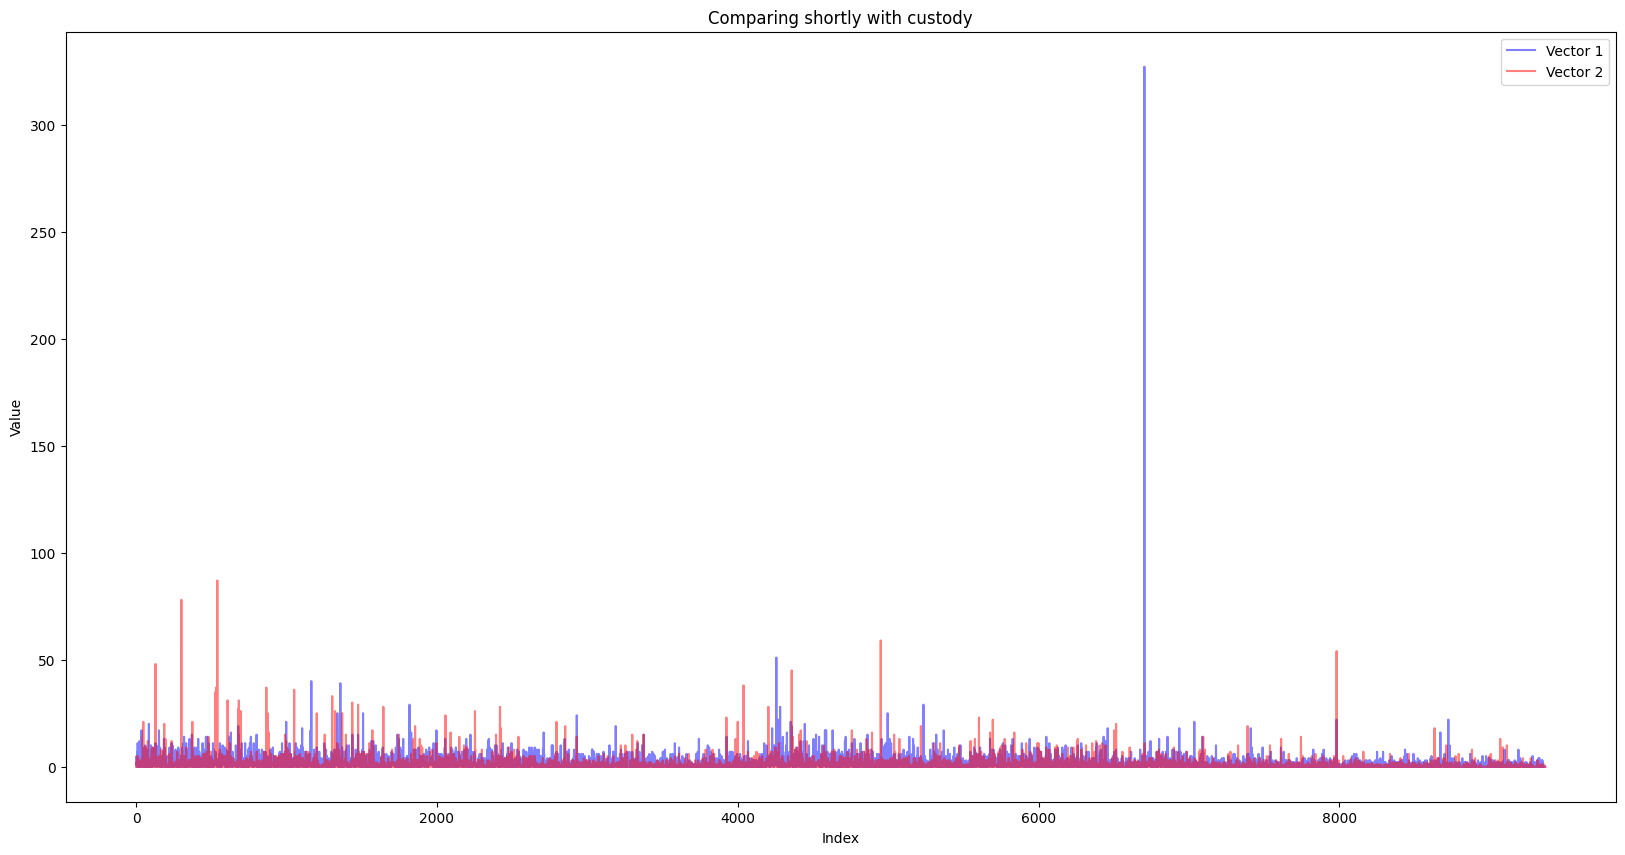

In [9]:
def plot_two_vectors(vector1, vector2, title="Comparison of Two Vectors", plot_type='line'):
    plt.figure(figsize=(20, 10))  # Set the figure size
    if plot_type == 'scatter':
        s = 5
        # Scatter plot with alpha
        plt.scatter(range(len(vector1)), vector1, s=s, color='blue', label='Vector 1', alpha=0.5)
        plt.scatter(range(len(vector2)), vector2, s=s, color='red', label='Vector 2', alpha=0.5)
    elif plot_type == 'line':
        # Line plot with alpha
        plt.plot(range(len(vector1)), vector1, color='blue', label='Vector 1', alpha=0.5)
        plt.plot(range(len(vector2)), vector2, color='red', label='Vector 2', alpha=0.5)
    
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()  # Add a legend to distinguish the vectors
    plt.show()


mytarget = random.choice(list(myintensionality.third.keys()))
tgt2 = random.choice(list(myintensionality.third.keys()))
title = f"Comparing {mytarget} with {tgt2}"
vector1 = myintensionality.third[mytarget]  # Example vector, adjust to 
vector2 = myintensionality.third[tgt2]

#plot_two_vectors(vector1, vector2, plot_type='scatter', title=title)  # For scatter plot
plot_two_vectors(vector1, vector2, plot_type='line', title=title)  # For line plot


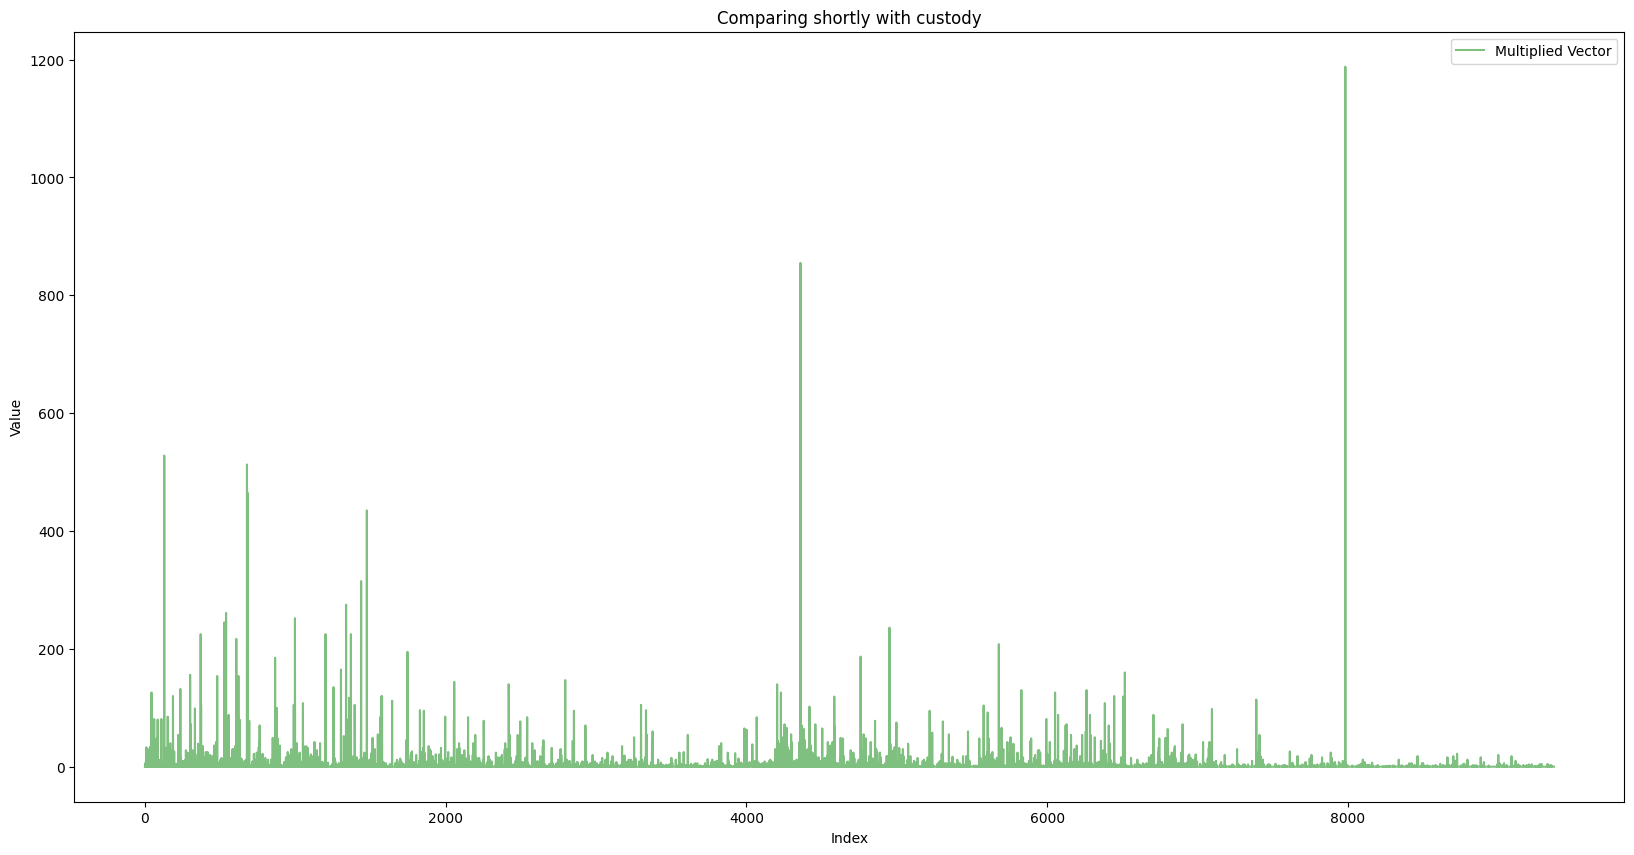

In [10]:
def plot_multiplied_vectors(vector1, vector2, title="Element-wise Multiplied Vector"):
    # Element-wise multiply the vectors
    multiplied_vector = np.multiply(vector1, vector2)
    
    plt.figure(figsize=(20, 10))  # Set the figure size
    # You can switch between 'line' and 'scatter' by commenting/uncommenting the appropriate lines
    # Line plot of the resulting vector
    plt.plot(range(len(multiplied_vector)), multiplied_vector, color='green', label='Multiplied Vector', alpha=0.5)
    # Scatter plot of the resulting vector
    # plt.scatter(range(len(multiplied_vector)), multiplied_vector, color='green', label='Multiplied Vector', alpha=0.5, s=5)

    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()  # Add a legend to distinguish the multiplied vector
    plt.show()

# Example usage
# Assuming vector1 and vector2 are defined in your current environment
plot_multiplied_vectors(vector1, vector2, title=title)


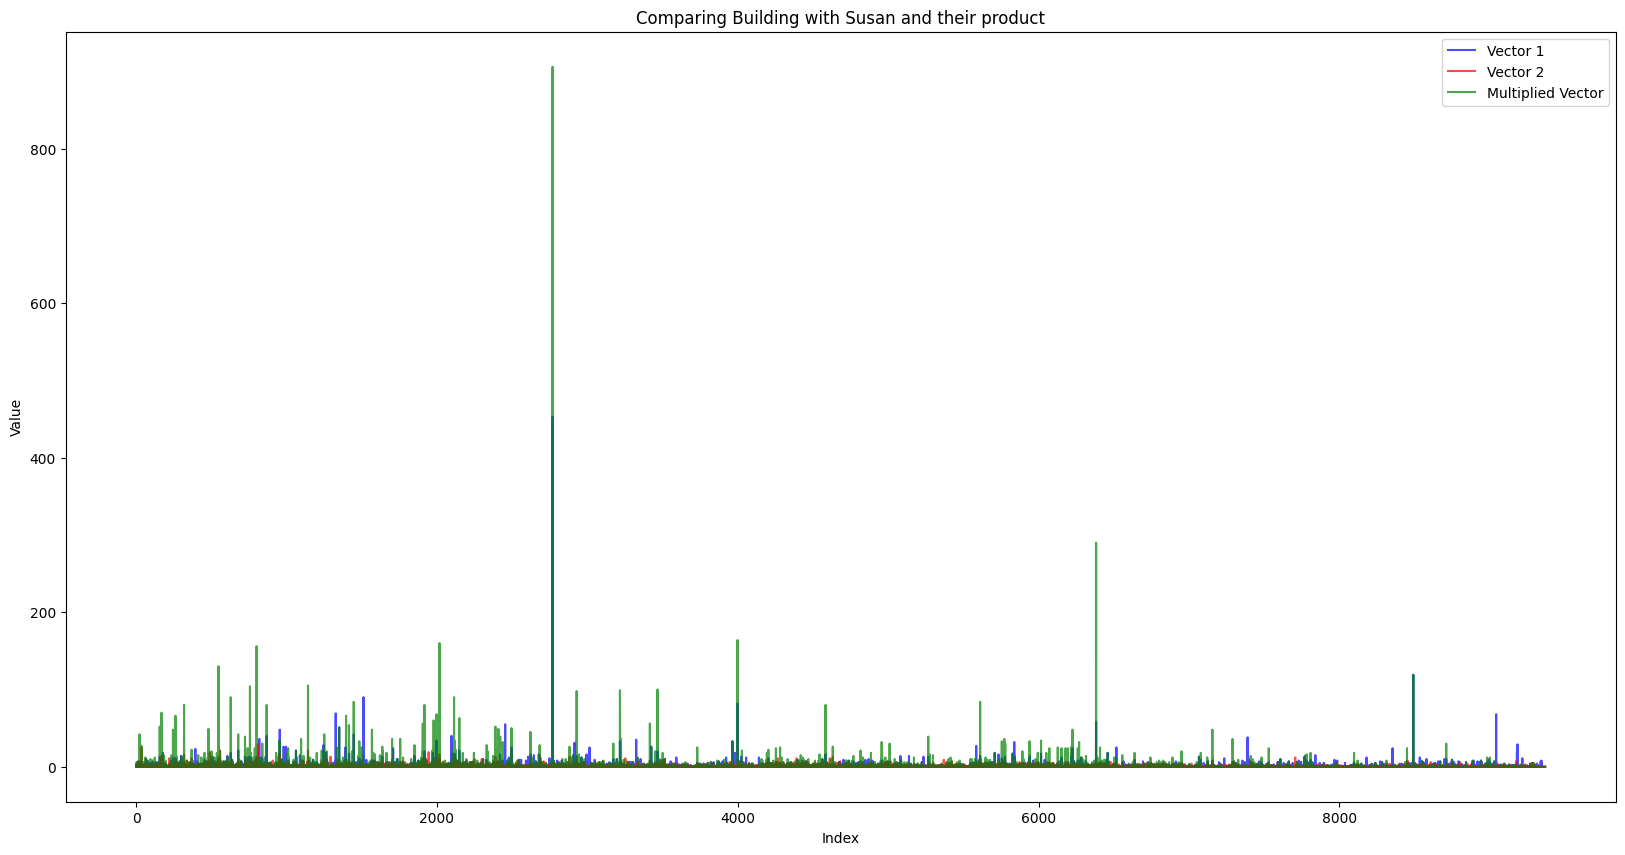

In [11]:
def plot_vectors_and_product(vector1, vector2, title="Vector Comparison and Product"):
    # Element-wise multiply the vectors
    multiplied_vector = np.multiply(vector1, vector2)

    plt.figure(figsize=(20, 10))  # Set the figure size

    # Plot the first vector
    plt.plot(range(len(vector1)), vector1, color='blue', label='Vector 1', alpha=0.7)
    # Plot the second vector
    plt.plot(range(len(vector2)), vector2, color='red', label='Vector 2', alpha=0.7)
    # Plot the element-wise multiplied result
    plt.plot(range(len(multiplied_vector)), multiplied_vector, color='green', label='Multiplied Vector', alpha=0.7)

    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()  # Add a legend to distinguish the vectors
    plt.show()

# Example usage:
# Assuming you have vector1 and vector2 defined in your environment, as derived from your dictionary
mytarget = random.choice(list(myintensionality.third.keys()))
tgt2 = random.choice(list(myintensionality.third.keys()))
title = f"Comparing {mytarget} with {tgt2} and their product"
vector1 = myintensionality.third[mytarget]
vector2 = myintensionality.third[tgt2]

plot_vectors_and_product(vector1, vector2, title=title)
